In [1]:
from sage.all import Graph, graphs


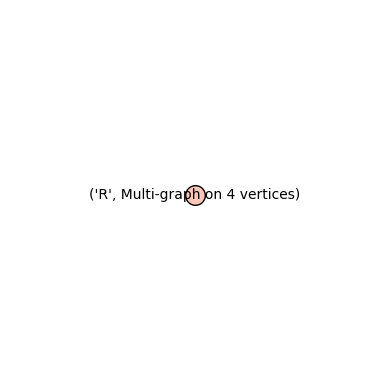

In [2]:
G = graphs.CompleteGraph(4)
spqr = G.spqr_tree()
spqr.plot()


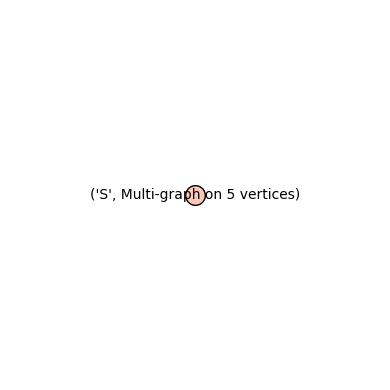

In [3]:
H = graphs.CycleGraph(5)
spqr = H.spqr_tree()
spqr.plot()


Original graph vertices: [1, 2, 3, 4, 5, 6]
Original graph edges: [(1, 2), (1, 3), (2, 4), (3, 5), (3, 6), (4, 5), (4, 6)]


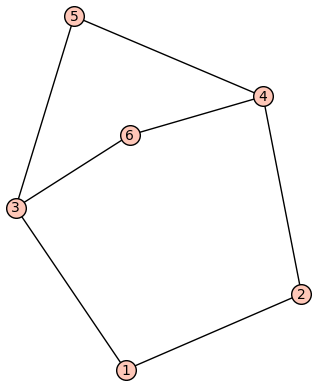

SPQR tree successfully computed.
SPQR tree has 4 nodes and 3 edges
Node 0: type=S, skeleton edges=[(3, 4), (3, 6), (4, 6)]
Node 1: type=S, skeleton edges=[(3, 4), (3, 5), (4, 5)]
Node 2: type=P, skeleton edges=[(3, 4), (3, 4), (3, 4)]
Node 3: type=S, skeleton edges=[(1, 2), (1, 3), (2, 4), (3, 4)]
SPQR tree edge: (('P', Multi-graph on 2 vertices), ('S', Multi-graph on 3 vertices))
SPQR tree edge: (('P', Multi-graph on 2 vertices), ('S', Multi-graph on 3 vertices))
SPQR tree edge: (('P', Multi-graph on 2 vertices), ('S', Multi-graph on 4 vertices))


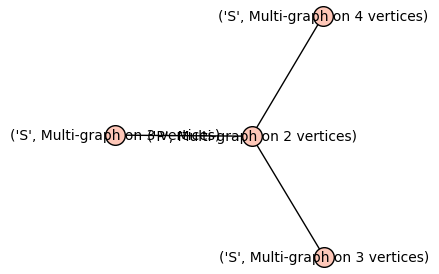

In [14]:
# Define the graph
edges = [(1,2), (1,3), (3,5), (3,6), (5,4), (6,4), (4,2)]
K = Graph(edges)

print("Original graph vertices:", K.vertices())
print("Original graph edges:", K.edges(labels=False))
K.show()

try:
    spqr = K.spqr_tree()
    print("SPQR tree successfully computed.")
    print(f"SPQR tree has {spqr.num_verts()} nodes and {spqr.num_edges()} edges")

    # Extract vertices without forcing comparison
    vertices = list(spqr.vertex_iterator())
    for i, v in enumerate(vertices):
        node_type, skeleton = v
        print(f"Node {i}: type={node_type}, skeleton edges={skeleton.edges(labels=False)}")

    # Extract edges safely
    edges = list(spqr.edge_iterator(labels=False))
    for e in edges:
        print("SPQR tree edge:", e)

    # Visualize
    spqr.show()
except Exception as e:
    print("SPQR decomposition failed at inspection:", e)


In [17]:
# Build the graph
edges = [(1,2), (1,3), (3,5), (3,6), (5,4), (6,4), (4,2)]
K = Graph(edges)

print("Original graph vertices:", K.vertices())
print("Original graph edges:", K.edges(labels=False))

# Compute SPQR-tree
spqr = K.spqr_tree()
print("SPQR tree has", spqr.order(), "nodes and", spqr.size(), "edges")

# Pick root edge
root_edge = (1,2)

# Step 1. Find the node whose skeleton contains (1,2)
def find_edge_owner(spqr, edge):
    for v in spqr.vertices(sort=False):   # vertices are like ('S', Graph)
        node_type, skel = v               # unpack directly
        edge_list = skel.edges(labels=False)
        if edge in edge_list or edge[::-1] in edge_list:
            return v
    return None

root_edge = (1, 2)
owner = find_edge_owner(spqr, root_edge)
print("Owner of edge", root_edge, "is SPQR node", owner)


# Step 2. Build a new SPQR tree rooted at a synthetic Q-node
from sage.graphs.graph import Graph as SageGraph

rooted_spqr = SageGraph(multiedges=True)
rooted_spqr.add_vertex(("Q", root_edge))
rooted_spqr.add_edge(("Q", root_edge), owner)

print("\n--- Rooted SPQR-tree ---")
print("Root:", ("Q", root_edge))
print("Children of root:", rooted_spqr.neighbors(("Q", root_edge)))

# You can now traverse this rooted tree manually
# Example: show skeleton of the child
skel = spqr.get_skeleton(owner)
print("Skeleton at owner:", skel.edges(labels=False))


Original graph vertices: [1, 2, 3, 4, 5, 6]
Original graph edges: [(1, 2), (1, 3), (2, 4), (3, 5), (3, 6), (4, 5), (4, 6)]
SPQR tree has 4 nodes and 3 edges


LookupError: one of the two vertices does not belong to the graph

Original graph vertices: [1, 2, 3, 4, 5, 6]
Original graph edges: [(1, 2), (1, 3), (2, 4), (3, 5), (3, 6), (4, 5), (4, 6)]


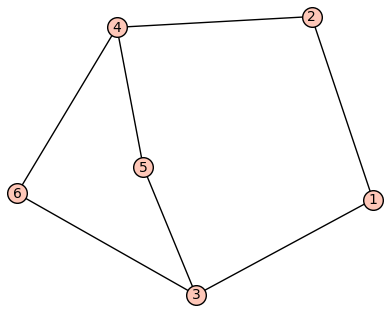

SPQR tree has 4 nodes and 3 edges
Owner of edge (1, 2) is SPQR node: type=S, skeleton edges=[(1, 2), (1, 3), (2, 4), (3, 4)]

Full SPQR tree nodes:
  type=S, skeleton edges=[(3, 4), (3, 6), (4, 6)]
  type=S, skeleton edges=[(3, 4), (3, 5), (4, 5)]
  type=P, skeleton edges=[(3, 4), (3, 4), (3, 4)]
  type=S, skeleton edges=[(1, 2), (1, 3), (2, 4), (3, 4)]

SPQR tree edges:


TypeError: '<' not supported between instances of 'Graph' and 'Graph'

In [18]:
# Define the graph
edges = [(1,2), (1,3), (3,5), (3,6), (5,4), (6,4), (4,2)]
K = Graph(edges)

print("Original graph vertices:", K.vertices())
print("Original graph edges:", K.edges(labels=False))
K.show()

# Compute SPQR decomposition
spqr = K.spqr_tree()
print(f"SPQR tree has {spqr.num_verts()} nodes and {spqr.num_edges()} edges")

# Utility: pretty-print a node
def describe_node(node):
    node_type, skel = node
    return f"type={node_type}, skeleton edges={skel.edges(labels=False)}"

# Step 1. Find the node whose skeleton explicitly contains (1,2)
def find_edge_owner(spqr, edge):
    u, v = edge
    for node_type, skel in spqr.vertices(sort=False):
        for (a, b) in skel.edges(labels=False):
            # Order-independent comparison
            if {a, b} == {u, v}:
                return (node_type, skel)
    return None

# Root edge
root_edge = (1, 2)
owner = find_edge_owner(spqr, root_edge)

if owner is None:
    print(f"Edge {root_edge} does not appear literally in any skeleton (may be virtual).")
else:
    print(f"Owner of edge {root_edge} is SPQR node: {describe_node(owner)}")

# Optional: print all nodes for inspection
print("\nFull SPQR tree nodes:")
for node in spqr.vertices(sort=False):
    print(" ", describe_node(node))

print("\nSPQR tree edges:")
for e in spqr.edges(labels=False):
    print(" ", e)


Original graph vertices: [1, 2, 3, 4, 5, 6]
Original graph edges: [(1, 2), (1, 3), (2, 4), (3, 5), (3, 6), (4, 5), (4, 6)]


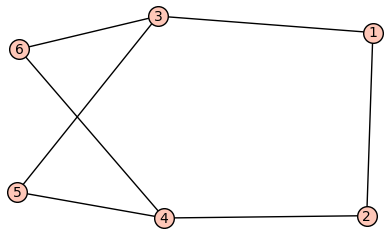

SPQR tree has 4 nodes and 3 edges
Owner of edge (1, 2) is: type=S, skeleton edges=[(1, 2), (1, 3), (2, 4), (3, 4)]


TypeError: This graph is mutable, and thus not hashable. Create an immutable copy by `g.copy(immutable=True)`

In [19]:
# Define the graph
edges = [(1,2), (1,3), (3,5), (3,6), (5,4), (6,4), (4,2)]
K = Graph(edges)

print("Original graph vertices:", K.vertices())
print("Original graph edges:", K.edges(labels=False))
K.show()

# Compute SPQR tree
spqr = K.spqr_tree()
print(f"SPQR tree has {spqr.num_verts()} nodes and {spqr.num_edges()} edges")

# Describe nodes nicely
def describe_node(node):
    node_type, skel = node
    return f"type={node_type}, skeleton edges={skel.edges(labels=False)}"

# Find owner of (1,2)
root_edge = (1,2)
owner = None
for node_type, skel in spqr.vertices(sort=False):
    for (a,b) in skel.edges(labels=False):
        if {a,b} == set(root_edge):
            owner = (node_type, skel)
            break

print(f"Owner of edge {root_edge} is: {describe_node(owner)}")

# ---- Build rooted SPQR tree with Q-node root ----
RootQ = ("Q", Graph([root_edge]))   # new artificial Q-node
Rtree = Graph(multiedges=True, loops=False)

# Add all old nodes + root
for v in spqr.vertices(sort=False):
    Rtree.add_vertex(v)
Rtree.add_vertex(RootQ)

# Add old edges
for u,v in spqr.edges(labels=False):
    Rtree.add_edge(u,v)

# Connect Q-root to its owner
Rtree.add_edge(RootQ, owner)

print("\nRooted SPQR tree nodes:")
for v in Rtree.vertices(sort=False):
    print(" ", describe_node(v))

print("\nRooted SPQR tree edges:")
for (u,v) in Rtree.edges(labels=False):
    print(" ", (describe_node(u), describe_node(v)))

# Optional: visualize
Rtree.show()


In [20]:
# Define the graph
edges = [(1,2), (1,3), (2,4), (3,5), (3,6), (4,5), (4,6)]
K = Graph(edges)

print("Original graph vertices:", K.vertices())
print("Original graph edges:", K.edges(labels=False))

# Compute SPQR tree
spqr = K.spqr_tree()
print(f"\nSPQR tree has {spqr.num_verts()} nodes and {spqr.num_edges()} edges")

# Helper to describe nodes
def describe_node(node):
    node_type, skel = node
    return f"type={node_type}, skeleton edges={skel.edges(labels=False)}"

# Find owner of edge (1,2)
root_edge = (1,2)
owner = None
for node_type, skel in spqr.vertices(sort=False):
    for (a,b) in skel.edges(labels=False):
        if {a,b} == set(root_edge):
            owner = (node_type, skel)
            break

print(f"Owner of edge {root_edge} is: {describe_node(owner)}")

# ---- Build rooted SPQR tree with Q-node root ----
RootQ = ("Q", Graph([root_edge]).copy(immutable=True))   # immutable skeleton

Rtree = Graph(multiedges=True, loops=False)

# Add all old nodes + root
for v in spqr.vertices(sort=False):
    Rtree.add_vertex(v)
Rtree.add_vertex(RootQ)

# Add old edges
for u,v in spqr.edges(labels=False):
    Rtree.add_edge(u,v)

# Connect Q-root to its owner
Rtree.add_edge(RootQ, owner)

print("\nRooted SPQR tree nodes:")
for v in Rtree.vertices(sort=False):
    print(" ", describe_node(v))

print("\nRooted SPQR tree edges:")
for (u,v) in Rtree.edges(labels=False):
    print(" ", (describe_node(u), describe_node(v)))


Original graph vertices: [1, 2, 3, 4, 5, 6]
Original graph edges: [(1, 2), (1, 3), (2, 4), (3, 5), (3, 6), (4, 5), (4, 6)]

SPQR tree has 4 nodes and 3 edges
Owner of edge (1, 2) is: type=S, skeleton edges=[(1, 2), (1, 3), (2, 4), (3, 4)]


TypeError: '<' not supported between instances of 'Graph' and 'Graph'

In [21]:
from sage.all import *

# ------------------------------
# Original graph
# ------------------------------
G = Graph()
G.add_edges([
    (1, 2), (1, 3), (2, 4),
    (3, 5), (3, 6), (4, 5), (4, 6)
])
print("Original graph vertices:", list(G.vertices()))
print("Original graph edges:", list(G.edges(labels=False)))

# ------------------------------
# SPQR decomposition
# ------------------------------
spqr = G.spqr_tree()
print("\nSPQR tree has", spqr.num_verts(), "nodes and", spqr.num_edges(), "edges")

# ------------------------------
# Helper to describe node
# ------------------------------
def describe_node(node):
    ntype, skel = node
    edges = skel.edges(labels=False)
    return f"type={ntype}, skeleton edges={edges}"

# ------------------------------
# Step 1. Find which SPQR node owns (1,2)
# ------------------------------
def find_edge_owner(spqr, edge):
    for v in spqr.vertices(sort=False):
        ntype, skel = v
        edges = skel.edges(labels=False)
        if edge in edges or (edge[::-1] in edges):
            return v
    return None

root_edge = (1,2)
owner = find_edge_owner(spqr, root_edge)
print("Owner of edge", root_edge, "is:", describe_node(owner))

# ------------------------------
# Step 2. Create Q-node for (1,2)
# ------------------------------
Qgraph = Graph()
Qgraph.add_edge(root_edge)
RootQ = ('Q', Qgraph.copy(immutable=True))

# ------------------------------
# Step 3. Build rooted SPQR tree
# ------------------------------
Rtree = Graph(multiedges=False)

# Add all original SPQR vertices
for v in spqr.vertices(sort=False):
    Rtree.add_vertex(v)

# Add Q root
Rtree.add_vertex(RootQ)

# Add all original edges (disable sorting!)
for (u,v) in spqr.edges(sort=False, labels=False):
    Rtree.add_edge(u,v)

# Connect Q root to owner of (1,2)
Rtree.add_edge(RootQ, owner)

# ------------------------------
# Step 4. Print result
# ------------------------------
print("\nRooted SPQR tree nodes:")
for v in Rtree.vertices(sort=False):
    print(" ", describe_node(v))

print("\nRooted SPQR tree edges:")
for (u,v) in Rtree.edges(sort=False, labels=False):
    print(" ", (describe_node(u), describe_node(v)))


Original graph vertices: [1, 2, 3, 4, 5, 6]
Original graph edges: [(1, 2), (1, 3), (2, 4), (3, 5), (3, 6), (4, 5), (4, 6)]

SPQR tree has 4 nodes and 3 edges


LookupError: one of the two vertices does not belong to the graph

Original graph vertices: [1, 2, 3, 4, 5, 6]
Original graph edges: [(1, 2), (1, 3), (2, 4), (3, 5), (3, 6), (4, 5), (4, 6)]


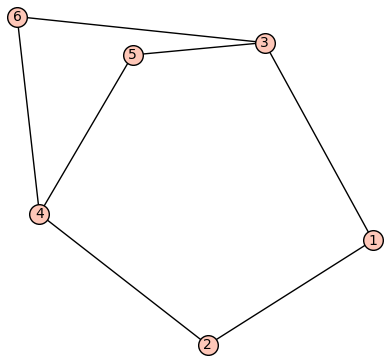

SPQR tree successfully computed.
SPQR tree has 4 nodes and 3 edges


ValueError: Could not find a Q-node for edge (1,2) in the SPQR tree. Check that (1,2) is an edge of K and that K is biconnected.

In [22]:
# SageMath code

# --- 1) Build the input graph ---
edges = [(1,2), (1,3), (3,5), (3,6), (5,4), (6,4), (4,2)]
K = Graph(edges)

print("Original graph vertices:", K.vertices())
print("Original graph edges:", K.edges(labels=False))
K.show()

# --- 2) Compute SPQR tree (as an unrooted tree whose vertices are (type, skeleton)) ---
from sage.graphs.connectivity import spqr_tree as spqr_tree_fn
T = spqr_tree_fn(K)          # same as K.spqr_tree(), but explicit import for clarity
print("SPQR tree successfully computed.")
print(f"SPQR tree has {T.num_verts()} nodes and {T.num_edges()} edges")

# Convenience: list vertices once
nodes = list(T.vertex_iterator())

# --- 3) Find the Q-node for the real edge (1,2) and root the tree there ---
target_edge = {1, 2}  # use a set to ignore order

def skeleton_has_real_edge(skel, uv_set):
    """
    Return True if the skeleton contains the real edge whose endpoints match uv_set.
    In Sage's SPQR internals, real edges typically have label None; virtual edges have a string label.
    """
    for (u, v, lbl) in skel.edges(labels=True):
        if {u, v} == uv_set and (lbl is None):
            return True
    return False

root_node = None
for v in nodes:
    v_type, skel = v
    if v_type == 'Q' and skeleton_has_real_edge(skel, target_edge):
        root_node = v
        break

if root_node is None:
    raise ValueError("Could not find a Q-node for edge (1,2) in the SPQR tree. "
                     "Check that (1,2) is an edge of K and that K is biconnected.")

print("Rooting SPQR tree at Q-node for edge (1,2).")

# --- 4) Create a rooted orientation (DiGraph) by BFS from the chosen Q-node ---
# Orient every undirected tree edge away from the root for easy traversal/printing.
from collections import deque

# Map objects to indices for stable display if desired (optional)
id_of = {v:i for i, v in enumerate(nodes)}

# Build adjacency for the undirected SPQR tree
adj = {v: [] for v in nodes}
for (a, b, _) in T.edge_iterator(labels=True):
    adj[a].append(b)
    adj[b].append(a)

# BFS to orient edges and gather parent/children
parent = {root_node: None}
order = []
Q = deque([root_node])
while Q:
    u = Q.popleft()
    order.append(u)
    for w in adj[u]:
        if w not in parent:
            parent[w] = u
            Q.append(w)

# Build a directed version oriented from the root
Td = DiGraph()
for v in nodes:
    Td.add_vertex(v)
for v, p in parent.items():
    if p is not None:
        Td.add_edge(p, v)

# --- 5) Print a readable summary in rooted order ---
def skel_edge_list_short(skel, max_show=6):
    es = list(skel.edges(labels=False))
    if len(es) <= max_show:
        return es
    return es[:max_show] + [f"... (+{len(es)-max_show} more)"]

print("\nRooted SPQR nodes in BFS order from Q[(1,2)]:")
for i, v in enumerate(order):
    v_type, skel = v
    par = parent[v]
    par_idx = None if par is None else id_of[par]
    print(f"[{i}] type={v_type}, parent_idx={par_idx}, "
          f"skeleton edges (sample)={skel_edge_list_short(skel)}")

print("\nOriented (parent -> child) edges in the rooted SPQR tree:")
for (u, v) in Td.edge_iterator(labels=False):
    print(f"  {id_of[u]} -> {id_of[v]}")

# --- 6) Visualize ---
# Unrooted view:
T.show(title="SPQR tree (unrooted)")
# Rooted orientation view:
Td.show(title="SPQR tree rooted at Q-node for edge (1,2)")



Original graph vertices: [1, 2, 3, 4, 5, 6]
Original graph edges (with labels): [(1, 2, '__ROOT_EDGE__'), (1, 3, None), (2, 4, None), (3, 5, None), (3, 6, None), (4, 5, None), (4, 6, None)]


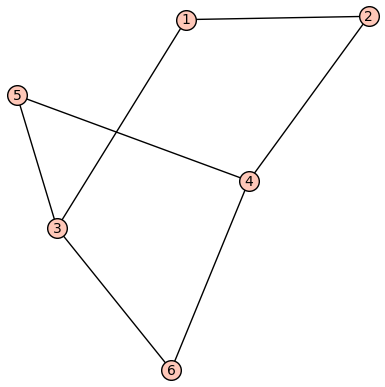

SPQR tree successfully computed.
SPQR tree has 4 nodes and 3 edges
Rooting SPQR tree at node containing edge (1, 2) (type = S ).

Nodes in BFS order from the chosen root:
[0] type=S, skeleton edges (sample)=[(1, 2, '__ROOT_EDGE__'), (1, 3, None), (2, 4, None), (3, 4, 'newVEdge2')]
[1] type=P, skeleton edges (sample)=[(3, 4, 'newVEdge0'), (3, 4, 'newVEdge1'), (3, 4, 'newVEdge2')]
[2] type=S, skeleton edges (sample)=[(3, 4, 'newVEdge0'), (3, 6, None), (4, 6, None)]
[3] type=S, skeleton edges (sample)=[(3, 4, 'newVEdge1'), (3, 5, None), (4, 5, None)]

Directed edges (parent -> child) in rooted SPQR tree:
  2 -> 0
  2 -> 1
  3 -> 2


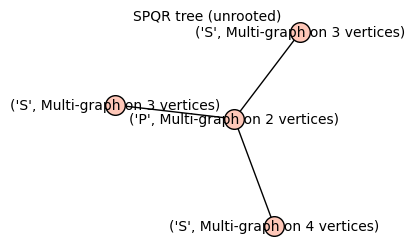

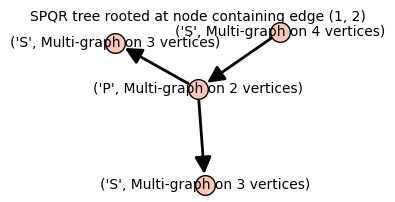

In [23]:
# SageMath code

# --- 1) Build the input graph and TAG the root edge (1,2) ---
raw_edges = [(1,2), (1,3), (3,5), (3,6), (5,4), (6,4), (4,2)]
ROOT_UV = (1, 2)
ROOT_TAG = "__ROOT_EDGE__"

# Rebuild edges with a unique label on (1,2) so we can find it later
labeled_edges = []
for (u, v) in raw_edges:
    if {u, v} == set(ROOT_UV):
        labeled_edges.append((u, v, ROOT_TAG))
    else:
        labeled_edges.append((u, v, None))

K = Graph(labeled_edges)  # multiedges not needed here; labels preserved

print("Original graph vertices:", K.vertices())
print("Original graph edges (with labels):", K.edges(labels=True))
K.show()

# --- 2) SPQR decomposition ---
from sage.graphs.connectivity import spqr_tree as spqr_tree_fn
T = spqr_tree_fn(K)
print("SPQR tree successfully computed.")
print(f"SPQR tree has {T.num_verts()} nodes and {T.num_edges()} edges")

nodes = list(T.vertex_iterator())

# --- 3) Find the node whose skeleton contains the ROOT_TAG real edge ---
def skeleton_contains_root_edge(skel):
    for (a, b, lab) in skel.edges(labels=True):
        # Match by label first (robust across integer/Integer vertex types)
        if lab == ROOT_TAG:
            return True
    return False

root_node = None
for v in nodes:
    if skeleton_contains_root_edge(v[1]):
        root_node = v
        break

if root_node is None:
    raise ValueError("Could not locate the tagged root edge in any SPQR skeleton. "
                     "Ensure the input graph uses the labeled edge list above.")

print("Rooting SPQR tree at node containing edge", ROOT_UV, "(type =", root_node[0], ").")

# --- 4) Orient the (unrooted) SPQR tree away from the chosen root for traversal ---
from collections import deque

adj = {v: [] for v in nodes}
for (x, y, _) in T.edge_iterator(labels=True):
    adj[x].append(y)
    adj[y].append(x)

parent = {root_node: None}
order = []
Q = deque([root_node])
while Q:
    u = Q.popleft()
    order.append(u)
    for w in adj[u]:
        if w not in parent:
            parent[w] = u
            Q.append(w)

Td = DiGraph()
for v in nodes:
    Td.add_vertex(v)
for v, p in parent.items():
    if p is not None:
        Td.add_edge(p, v)

# --- 5) Summaries ---
def short_edges(skel, limit=6):
    es = list(skel.edges(labels=True))
    return es if len(es) <= limit else es[:limit] + [f"...(+{len(es)-limit} more)"]

print("\nNodes in BFS order from the chosen root:")
for i, v in enumerate(order):
    t, sk = v
    print(f"[{i}] type={t}, skeleton edges (sample)={short_edges(sk)}")

print("\nDirected edges (parent -> child) in rooted SPQR tree:")
idx = {v:i for i, v in enumerate(nodes)}
for (u, v) in Td.edge_iterator(labels=False):
    print(f"  {idx[u]} -> {idx[v]}")

# --- 6) Visualize (optional) ---
T.show(title="SPQR tree (unrooted)")
Td.show(title=f"SPQR tree rooted at node containing edge {ROOT_UV}")
